# Lab 6

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [1]:
# Import the libraries we'll use below.
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
from matplotlib import pyplot as plt

sns.set(style="darkgrid")  # default style

import re

import tensorflow as tf
from keras import metrics
from tensorflow import keras

tf.get_logger().setLevel("INFO")
tf.config.set_visible_devices([], 'GPU')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


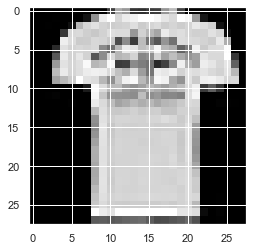

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(
    (X_train_fashion, Y_train_fashion),
    (X_test_fashion, Y_test_fashion),
) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.0
X_test_fashion = X_test_fashion / 255.0

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = [
    "t-shirt",
    "trouser",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print("Label: %s" % label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap="gray")
plt.show()

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


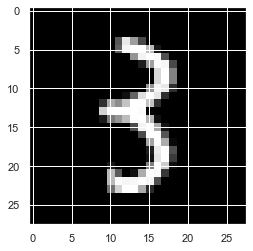

In [3]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print("Label: %d" % Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap="gray")
plt.show()

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (58points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition.

In [4]:
def build_model(
    n_classes,
    hidden_layer_sizes=[],
    activation="relu",
    optimizer="SGD",
    learning_rate=0.01,
):
    """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    model = keras.Sequential()

    model.add(keras.layers.Flatten())

    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=hidden_layer_size, activation=activation))

    model.add(keras.layers.Dense(units=n_classes, activation="softmax"))

    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

data='digits' hidden_layer_sizes=[] activation='tanh' optimizer='Adam' learning_rate=0.01
Training...


2022-06-04 17:22:59.578758: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


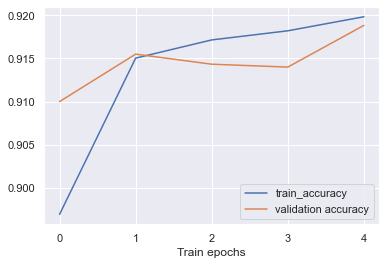

Total Parameters: 7,850 Test Accuracy: 0.9207


In [5]:
def train_and_evaluate(
    data="digits",
    hidden_layer_sizes=[],
    activation="tanh",
    optimizer="Adam",
    learning_rate=0.01,
    num_epochs=5,
):

    # Build the model.
    model = build_model(
        n_classes=10,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate,
    )

    # Select the dataset.
    if data == "digits":
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    elif data == "fashion":
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise "Unsupported dataset: %s" % data

    # Train the model.
    print(f"{data=} {hidden_layer_sizes=} {activation=} {optimizer=} {learning_rate=}")
    print("Training...")
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0,
    )

    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    plt.plot(train_accuracy, label="train_accuracy")
    plt.plot(val_accuracy, label="validation accuracy")
    plt.xticks(range(num_epochs))
    plt.xlabel("Train epochs")
    plt.legend()
    plt.show()

    test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0, return_dict=True)[
        "accuracy"
    ]

    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    summarystring = "\n".join(stringlist)
    total_parameter_string = re.search("Total params: (.*)\n", summarystring).group(1)

    print(
        f"Total Parameters: {total_parameter_string} Test Accuracy: {test_accuracy:.4f}"
    )

    return round(test_accuracy, 4), total_parameter_string


train_and_evaluate()
pass

---
### Exercise 2 (8 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01| 7,850 | 0.8964 |
digits|[]|relu|SGD|0.01| 7,850 | 0.8964 |
digits|[]|relu|Adam|0.01| 7,850| 0.9210 |
digits|[128]|relu|Adam|0.01|101,770| 0.9678 |
digits|[256,128]|relu|Adam|0.01| 235,146| 0.9680 |
-
fashion|[]|tanh|SGD|0.01| 7,850 | 0.8096 |
fashion|[]|relu|SGD|0.01| 7,850 | 0.8096 |
fashion|[]|relu|Adam|0.01| 7,850| 0.8355 |
fashion|[128]|relu|Adam|0.01| 101,770 | 0.8473 |
fashion|[256,128]|relu|Adam|0.01| 235,146| 0.8604 |




Commencing Experiment:
data='digits' hidden_layer_sizes=[] activation='tanh' optimizer='SGD' learning_rate=0.01
Training...


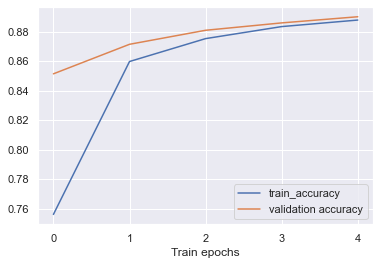

Total Parameters: 7,850 Test Accuracy: 0.8966


Commencing Experiment:
data='digits' hidden_layer_sizes=[] activation='relu' optimizer='SGD' learning_rate=0.01
Training...


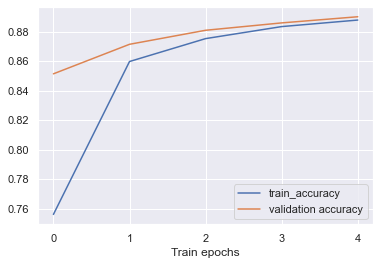

Total Parameters: 7,850 Test Accuracy: 0.8966


Commencing Experiment:
data='digits' hidden_layer_sizes=[] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


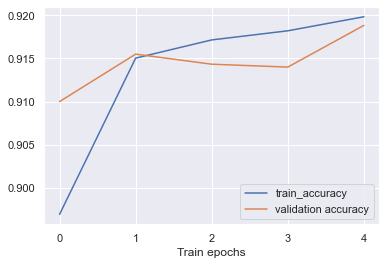

Total Parameters: 7,850 Test Accuracy: 0.9207


Commencing Experiment:
data='digits' hidden_layer_sizes=[128] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


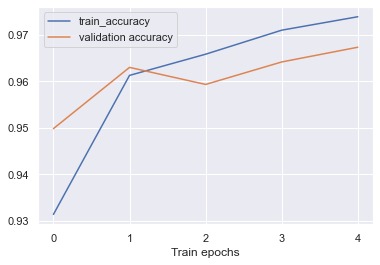

Total Parameters: 101,770 Test Accuracy: 0.9646


Commencing Experiment:
data='digits' hidden_layer_sizes=[256, 128] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


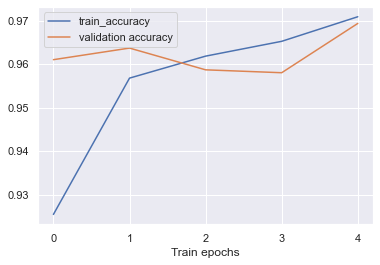

Total Parameters: 235,146 Test Accuracy: 0.9676


Commencing Experiment:
data='fashion' hidden_layer_sizes=[] activation='tanh' optimizer='SGD' learning_rate=0.01
Training...


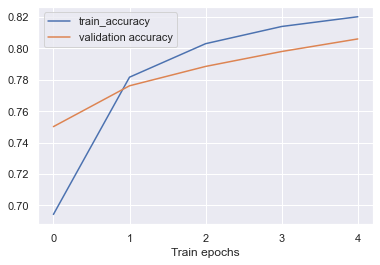

Total Parameters: 7,850 Test Accuracy: 0.8092


Commencing Experiment:
data='fashion' hidden_layer_sizes=[] activation='relu' optimizer='SGD' learning_rate=0.01
Training...


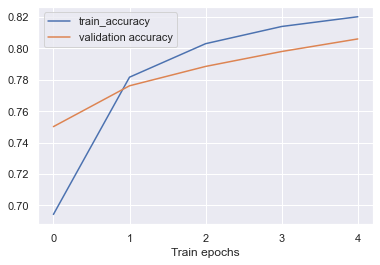

Total Parameters: 7,850 Test Accuracy: 0.8092


Commencing Experiment:
data='fashion' hidden_layer_sizes=[] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


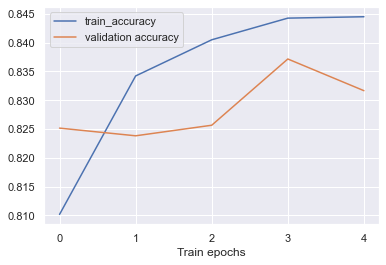

Total Parameters: 7,850 Test Accuracy: 0.8356


Commencing Experiment:
data='fashion' hidden_layer_sizes=[128] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


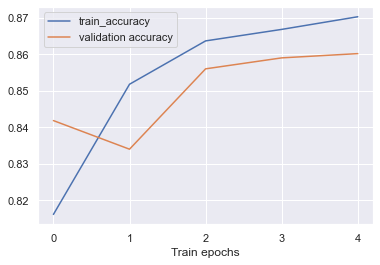

Total Parameters: 101,770 Test Accuracy: 0.8545


Commencing Experiment:
data='fashion' hidden_layer_sizes=[256, 128] activation='relu' optimizer='Adam' learning_rate=0.01
Training...


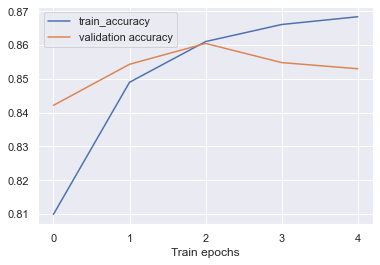

Total Parameters: 235,146 Test Accuracy: 0.8488





,Data,Hidden Sizes,Activation,Optimizer,Learning Rate,Total Parameter Count,Test Accuracy
0,digits,[],tanh,SGD,0.01,"7,850",0.8966
1,digits,[],relu,SGD,0.01,"7,850",0.8966
2,digits,[],relu,Adam,0.01,"7,850",0.9207
3,digits,[128],relu,Adam,0.01,"101,770",0.9646
4,digits,"[256, 128]",relu,Adam,0.01,"235,146",0.9676
5,fashion,[],tanh,SGD,0.01,"7,850",0.8092
6,fashion,[],relu,SGD,0.01,"7,850",0.8092
7,fashion,[],relu,Adam,0.01,"7,850",0.8356
8,fashion,[128],relu,Adam,0.01,"101,770",0.8545
9,fashion,"[256, 128]",relu,Adam,0.01,"235,146",0.8488


29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
%%timeit -r 1 -n 1

arguments = (
    ("digits", [], "tanh", "SGD", 0.01),
    ("digits", [], "relu", "SGD", 0.01),
    ("digits", [], "relu", "Adam", 0.01),
    ("digits", [128], "relu", "Adam", 0.01),
    ("digits", [256, 128], "relu", "Adam", 0.01),
    ("fashion", [], "tanh", "SGD", 0.01),
    ("fashion", [], "relu", "SGD", 0.01),
    ("fashion", [], "relu", "Adam", 0.01),
    ("fashion", [128], "relu", "Adam", 0.01),
    ("fashion", [256, 128], "relu", "Adam", 0.01),
)

results = []

for data, hidden_layer_sizes, activation, optimizer, learning_rate in arguments:
    print("\n\nCommencing Experiment:")
    accuracy, total_parameters = train_and_evaluate(
        data=data,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate,
    )
    results.append(
        [
            data,
            hidden_layer_sizes,
            activation,
            optimizer,
            learning_rate,
            total_parameters,
            round(accuracy, 4),
        ]
    )

results = pd.DataFrame(
    results,
    columns=(
        [
            "Data",
            "Hidden Sizes",
            "Activation",
            "Optimizer",
            "Learning Rate",
            "Total Parameter Count",
            "Test Accuracy",
        ]
    ),
)
print("\n\n")
display(results)